# Data preprocessing

The main goal is to process data and prepare it for model building

The original function to flatten json features

In [1]:
# The number of entries to read in. Use it to have fast turn-around
max_events=None

import os
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.metrics import mean_squared_error

PATH='../'
#PATH='../input/flatten-json-fields-smart-dump-data/'

print(os.listdir(PATH))

['10.1016_j.cie.2016.08.009.pdf', 'GoogleAnalytics', 'test-flat.csv.gz', 'test-user.csv.gz', 'test_100.csv', 'test_10k.csv', 'test_v2_clip.csv', 'train-flat.csv.gz', 'train-user.csv.gz', 'train_v2_clip.csv']


## Let's load the original data with pre-processing

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object and col_type.name != 'category' and 'datetime' not in col_type.name:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        elif 'datetime' not in col_type.name:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def load_df(fin='../input/train.csv', nrows=None):
    df = pd.read_csv(fin, 
                     dtype={'fullVisitorId': 'str', # Important!!
                            'date': 'str'
                           },
                     parse_dates=['date'],
                     nrows=nrows)

    print("Loaded {}. Shape: {}".format(os.path.basename(fin), df.shape))
    return reduce_mem_usage(df)

In [3]:
%%time
df_trn = load_df(PATH + '/train-user.csv.gz',
                       nrows=max_events)
df_tst = load_df(PATH + "/test-user.csv.gz", 
                        nrows=max_events)

df_trn = pd.concat([df_trn, df_tst], axis=0)

Loaded train-user.csv.gz. Shape: (1708337, 42)
Memory usage of dataframe is 547.41 MB
Memory usage after optimization is: 219.77 MB
Decreased by 59.9%
Loaded test-user.csv.gz. Shape: (401589, 42)
Memory usage of dataframe is 128.68 MB
Memory usage after optimization is: 51.46 MB
Decreased by 60.0%
CPU times: user 54.2 s, sys: 3.57 s, total: 57.7 s
Wall time: 38.7 s


In [4]:
df_trn.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device_browser,device_object,device_deviceCategory,device_isMobile,...,geoNetwork_country_area,geoNetwork_country_population,geoNetwork_country_pop_density,geoNetwork_country_m2f,geoNetwork_country_gdp_growth,geoNetwork_country_gdp_capita,geoNetwork_country_unemployment,geoNetwork_country_pop_urban,geoNetwork_country_handy,geoNetwork_country_internet
0,Organic Search,2017-10-16,3162355547410993243,1508198450,1,1508198450,Firefox,NaN,desktop,0.0,...,357376.0,82114.0,235.625,97.0000,1.700195,41686.199219,4.199219,75.3125,116.6875,87.62500
1,Referral,2017-10-16,8934116514970143966,1508176307,6,1508176307,Chrome,NaN,desktop,0.0,...,9833517.0,324460.0,35.500,98.0000,2.599609,56053.800781,4.898438,81.6250,117.6250,74.62500
2,Direct,2017-10-16,7992466427990357681,1508201613,1,1508201613,Chrome,NaN,mobile,1.0,...,9833517.0,324460.0,35.500,98.0000,2.599609,56053.800781,4.898438,81.6250,117.6250,74.62500
3,Organic Search,2017-10-16,9075655783635761930,1508169851,1,1508169851,Chrome,NaN,desktop,0.0,...,783562.0,80745.0,104.875,97.0000,4.000000,9125.799805,10.796875,73.3750,96.0000,53.68750
4,Organic Search,2017-10-16,6960673291025684308,1508190552,1,1508190552,Chrome,NaN,desktop,0.0,...,1964375.0,129163.0,66.375,99.1875,2.500000,8980.900391,4.101562,79.1875,85.3125,57.40625


In [5]:
df_trn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2109926 entries, 0 to 401588
Data columns (total 42 columns):
channelGrouping                    category
date                               datetime64[ns]
fullVisitorId                      object
visitId                            int32
visitNumber                        int16
visitStartTime                     int32
device_browser                     object
device_object                      float64
device_deviceCategory              category
device_isMobile                    float16
device_operatingSystem             object
geoNetwork_city                    object
geoNetwork_continent               category
geoNetwork_country                 object
geoNetwork_metro                   object
geoNetwork_networkDomain           object
geoNetwork_region                  object
geoNetwork_subContinent            category
totals_pageviews                   int16
totals_hits                        int16
totals_bounces                     

In [6]:
def preprocess_df(df):
    df['totals_hits_DIV_pageviews'] = (df['totals_hits'] / df['totals_pageviews']).fillna(0)
    df['totals_hits_MIN_pageviews'] = (df['totals_hits'] - df['totals_pageviews']).fillna(0)
    df['dt_dayofweek'] = df['date'].dt.dayofweek
    df['dt_weekofyear'] = df['date'].dt.weekofyear
#     df['dt_days2Christmas'] = (df['date'] - pd.datetime(df['date'].dt.year.min(),12,25)).dt.days
    for c in df.columns:
        if c.startswith('dt_'):
            df[c] = df[c].astype(np.int16)            
    df['geoNetwork_networkExtension'] = (df['geoNetwork_networkDomain'].str.split('.', n=1).str[1]).fillna('NaN').astype('category')
    df['geoNetwork_networkSite'] = (df['geoNetwork_networkDomain'].str.split('.', n=1).str[0]).fillna('NaN').astype('category')
    
#     str_transforms = {'trafficSource_referralPath': [('nslashes', 'count', {'pat':'/'}),
#                                                      ('nequals', 'count', {'pat':'='}),
#                                                      ('len', 'len', {}),
#                                                      ('offer', 'contains', {'pat':'offer'}),
#                                                      ('deal', 'contains', {'pat':'deal'}),
#                                                      ('sale', 'contains', {'pat':'sale'}),
#                                                      ('mail', 'contains', {'pat':'/mail/u'}),
#                                                      ('google', 'contains', {'pat':'google'})
#                                                     ],
#                       #'trafficSource_adwordsClickInfo_gclId': [('len', 'len', {})]
#                      }    
#     for f_, list_trans_ in str_transforms.items():
#         for (name_, func_, pars_) in list_trans_:
#             f_new = 'str_{}_{}'.format(f_, name_)
#             df[f_new] = getattr(df[f_].str, func_)(**pars_)
#             if func_ == 'contains':
#                 df[f_new] = df[f_new].astype(bool)
#             else:
#                 df[f_new] = df[f_new].astype(np.float16)
                
                
preprocess_df(df_trn)
#preprocess_df(df_tst)

In [7]:
cols_cat = df_trn.select_dtypes(include=['category', 'object']).columns.tolist()
cols_cat.remove('fullVisitorId')
cols_num = df_trn.select_dtypes(exclude=['category']).columns.tolist()
cols_2drop = ['visitId', 'visitStartTime', #'date', 
              #'trafficSource_keyword', 
              'trafficSource_referralPath',
              #'trafficSource_source'
             ]

for c in df_tst.columns:
    if df_trn[c].isnull().sum() / df_trn.shape[0] > 0.99:
        cols_2drop.append(c)
for c in cols_2drop:
    if c in cols_cat:
        cols_cat.remove(c)


In [8]:
print('Categorical featuers:\n{}'.format(cols_cat))
print('\nFeatures to be dropped:\n{}'.format(cols_2drop))

Categorical featuers:
['channelGrouping', 'device_browser', 'device_deviceCategory', 'device_operatingSystem', 'geoNetwork_city', 'geoNetwork_continent', 'geoNetwork_country', 'geoNetwork_metro', 'geoNetwork_networkDomain', 'geoNetwork_region', 'geoNetwork_subContinent', 'trafficSource_adContent', 'trafficSource_campaign', 'trafficSource_medium', 'trafficSource_source', 'geoNetwork_networkExtension', 'geoNetwork_networkSite']

Features to be dropped:
['visitId', 'visitStartTime', 'trafficSource_referralPath', 'device_object']


In [9]:
def group_cat_cols(df, cols_2encode, threashold=0.001):
    for c in cols_2encode:
        print('================== {} =============='.format(c))        
        #print(df_trn[c].value_counts())
        negligible_cats = (df[c].value_counts()/df[c].notnull().sum()).loc[lambda x: x < threashold]
        #print(negligible_cats.shape, df_trn[c].nunique())
        group_cats = pd.Series(df[c].unique(), index=df[c].unique()).astype('object')
        group_cats.loc[negligible_cats.index] = 'GroupedLowFreq'
        df[c] = df[c].astype('object').map(group_cats)
    return df

df_trn = group_cat_cols(df_trn, cols_2encode=cols_cat)
#train_test_apply_func(df_trn, df_tst, group_cat_cols, cols_2encode=cols_cat)

================== channelGrouping ==============
================== device_browser ==============
================== device_deviceCategory ==============
================== device_operatingSystem ==============
================== geoNetwork_city ==============
================== geoNetwork_continent ==============
================== geoNetwork_country ==============
================== geoNetwork_metro ==============
================== geoNetwork_networkDomain ==============
================== geoNetwork_region ==============
================== geoNetwork_subContinent ==============
================== trafficSource_adContent ==============
================== trafficSource_campaign ==============
================== trafficSource_medium ==============
================== trafficSource_source ==============
================== geoNetwork_networkExtension ==============
================== geoNetwork_networkSite ==============


In [10]:
for df in [df_trn]:
    df['visitStartTime_hour'] = pd.to_datetime(df['visitStartTime'], unit='s').dt.hour
    # Get the absolute cyclic distance to the minimum location (9 am)
    df['visitStartTime_hour_diff9'] = np.absolute(df['visitStartTime_hour'] - 9)
    diff9_larger12 = df['visitStartTime_hour_diff9'] > 12
    df.loc[diff9_larger12,'visitStartTime_hour_diff9'] = 24 - df.loc[diff9_larger12,'visitStartTime_hour_diff9']
    del diff9_larger12


In [11]:
from sklearn.preprocessing import LabelEncoder

def LE_cols(df, cols_2encode):
    for c in cols_2encode:
        print(c)
        #print(df[c].unique())
        df[c], _ = pd.factorize(df[c])
        #print(df[c].unique())
    return df

for df_ in [df_trn]:
    df_.drop(cols_2drop, axis=1, inplace=True)
    
df_trn = LE_cols(df_trn, cols_2encode=cols_cat)
#df_trn, df_tst = train_test_apply_func(df_trn, df_tst, LE_cols, cols_2encode=cols_cat)

channelGrouping
device_browser
device_deviceCategory
device_operatingSystem
geoNetwork_city
geoNetwork_continent
geoNetwork_country
geoNetwork_metro
geoNetwork_networkDomain
geoNetwork_region
geoNetwork_subContinent
trafficSource_adContent
trafficSource_campaign
trafficSource_medium
trafficSource_source
geoNetwork_networkExtension
geoNetwork_networkSite


In [12]:
df_trn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2109926 entries, 0 to 401588
Data columns (total 46 columns):
channelGrouping                    int64
date                               datetime64[ns]
fullVisitorId                      object
visitNumber                        int16
device_browser                     int64
device_deviceCategory              int64
device_isMobile                    float16
device_operatingSystem             int64
geoNetwork_city                    int64
geoNetwork_continent               int64
geoNetwork_country                 int64
geoNetwork_metro                   int64
geoNetwork_networkDomain           int64
geoNetwork_region                  int64
geoNetwork_subContinent            int64
totals_pageviews                   int16
totals_hits                        int16
totals_bounces                     int8
totals_newVisits                   int8
totals_transactionRevenue          int64
totals_visits                      int8
totals_timeOnSite 

In [13]:
df_trn.head()

,channelGrouping,date,fullVisitorId,visitNumber,device_browser,device_deviceCategory,device_isMobile,device_operatingSystem,geoNetwork_city,geoNetwork_continent,...,geoNetwork_country_handy,geoNetwork_country_internet,totals_hits_DIV_pageviews,totals_hits_MIN_pageviews,dt_dayofweek,dt_weekofyear,geoNetwork_networkExtension,geoNetwork_networkSite,visitStartTime_hour,visitStartTime_hour_diff9
0,0,2017-10-16,3162355547410993243,1,0,0,0.0,0,0,0,...,116.6875,87.62500,1.0,0,0,42,0,0,0,9
1,1,2017-10-16,8934116514970143966,6,1,0,0.0,1,1,1,...,117.6250,74.62500,1.0,0,0,42,0,0,17,8
2,2,2017-10-16,7992466427990357681,1,1,1,1.0,2,0,1,...,117.6250,74.62500,1.0,0,0,42,1,1,0,9
3,0,2017-10-16,9075655783635761930,1,1,0,0.0,0,0,2,...,96.0000,53.68750,1.0,0,0,42,2,2,16,7
4,0,2017-10-16,6960673291025684308,1,1,0,0.0,0,0,1,...,85.3125,57.40625,1.0,0,0,42,3,3,21,12


In [14]:
df_tst = df_trn.iloc[df_trn.shape[0]-df_tst.shape[0]:]

# New CV schema

### Daily revenue

In [15]:
x = df_trn.groupby('date')['totals_transactionRevenue'].sum()

In [16]:
def plot_log_sum_daily_revenue(x, t_start=None, t_end=None, figsize=(15,3), ylim=(18,24)):
    _ = x.loc[t_start:t_end].plot(figsize=figsize, ylim=ylim)

#### Dec 2016 - Jan 2017

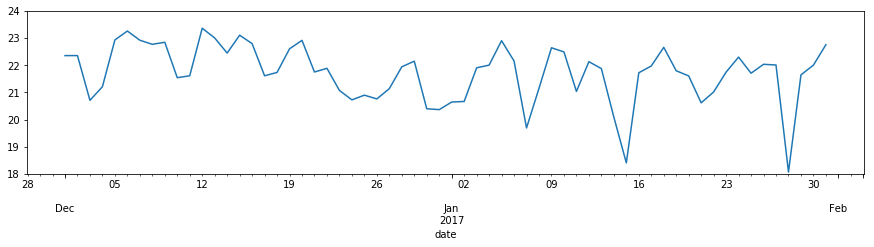

In [17]:
plot_log_sum_daily_revenue(np.log1p(x), '2016-12-01', '2017-01-31')

#### Full range

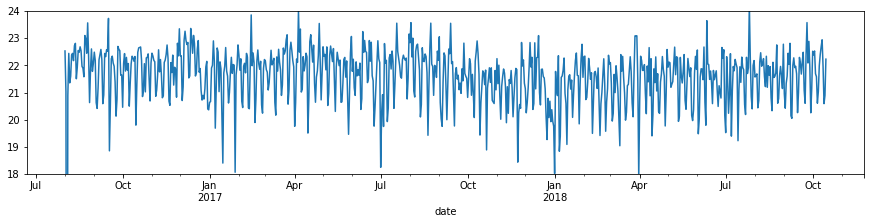

In [18]:
plot_log_sum_daily_revenue(np.log1p(x))

In [19]:
print('The TRAIN dataset spans from {} to {}'.format(df_trn['date'].min().date().isoformat(),
                                               df_trn['date'].max().date().isoformat()
                                              ))

The TRAIN dataset spans from 2016-08-01 to 2018-10-15


In [20]:
print('The TEST dataset spans from {} to {}'.format(df_tst['date'].min().date().isoformat(),
                                               df_tst['date'].max().date().isoformat()
                                              ))

The TEST dataset spans from 2018-05-01 to 2018-10-15


### Introduce time slicing

In [21]:
df_trn['date'].max()

Timestamp('2018-10-15 00:00:00')

In [22]:
def get_valid_date_range(i_fold, end_date, t_period=pd.Timedelta(days=30)):
    return end_date-(i_fold+1)*t_period, end_date-i_fold*t_period    

def split_trn_val_tst_idx(df_,
                          t_trn_end, t_val_end, t_tst_end, 
                          t_trn_start=None, t_val_start=None, t_tst_start=None):
    if t_val_start is None:
        t_val_start = t_trn_end
    if t_tst_start is None:
        t_tst_start = t_val_end

    df_tst_ = df_.set_index('date').loc[t_tst_start.date().isoformat():
                                      t_tst_end.date().isoformat()]
    df_val_ = df_.set_index('date').loc[t_val_start.date().isoformat():
                                       t_val_end.date().isoformat()]
    df_trn_ = df_.set_index('date').loc[t_trn_start.date().isoformat()
                                       if t_trn_start is not None else None:
                                       t_trn_end.date().isoformat()]
    #get the subset of tst with user ID's from val
    fullVisitorId_val = df_val_['fullVisitorId'].unique()
    df_tst_ = df_tst_.query('fullVisitorId in @fullVisitorId_val')
    
    return df_trn_, df_val_, df_tst_, fullVisitorId_val

In [23]:
t_period = pd.Timedelta(days=30)
t_start, t_end = get_valid_date_range(0, df_trn['date'].max(), t_period=t_period)

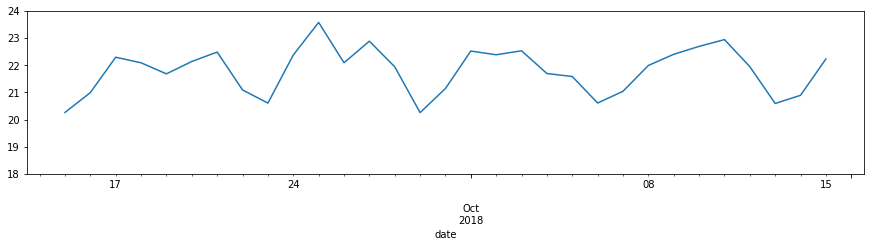

In [24]:
df_val = df_trn.set_index('date').loc[t_start.date().isoformat():t_end.date().isoformat()]
plot_log_sum_daily_revenue(np.log1p(df_val.groupby('date')['totals_transactionRevenue'].sum()))

In [25]:
def run_time_sampling(df_, n=5, days_tst=30, days_gap=0, days_val=30):
    td_tst = pd.Timedelta(days=days_tst)
    td_val = pd.Timedelta(days=days_val)
    td_gap = pd.Timedelta(days=days_gap)
    visits_val = np.zeros(n)
    visits_tst = np.zeros(n)
    users_non0_val = np.zeros(n)
    users_non0_tst_in_val = np.zeros(n)
    users_non0_tst_in_non0_val = np.zeros(n)
#     l = []
    for i in range(n):
        t_tst_start, t_tst_end = get_valid_date_range(i, df_['date'].max(), t_period=td_tst)
        t_val_start, t_val_end = t_tst_start-td_gap-td_val, t_tst_start-td_gap
        
        _, df_val, df_tst_in_val, fullVisitorId_val = split_trn_val_tst_idx(df_, 
                                                                            t_trn_end=t_val_start,
                                                                            t_val_end=t_val_end,
                                                                            t_tst_end=t_tst_end,
                                                                            t_tst_start=t_tst_start
                                                                           )
        # lists of visitor IDs
        user_revenue_val = df_val.groupby('fullVisitorId')['totals_transactionRevenue'].sum()
        fullVisitorId_non0_val = user_revenue_val[user_revenue_val>0].index.tolist()
        
        # numbers of visitors
        visits_tst[i] = df_tst_in_val['fullVisitorId'].nunique()
        visits_val[i] = fullVisitorId_val.shape[0]
        
        # number of val visitors, that did purchases
        users_non0_val[i] = (user_revenue_val>0).sum()
        
        # number of users  who returned in tst and made purchase
        tst_users_from_val_revenue = df_tst_in_val.groupby('fullVisitorId')['totals_transactionRevenue'].sum()
        users_non0_tst_in_val[i] = (tst_users_from_val_revenue>0).sum()
        
        # number of users, who purchased in val, returned in tst and made purchase
#         tst_users_from_non0_val_revenue = df_tst_in_non0_val.groupby('fullVisitorId')['totals_transactionRevenue'].sum()
#         users_non0_tst_in_non0_val[i] = (tst_users_from_non0_val_revenue>0).sum()

    return visits_val, visits_tst, users_non0_val, users_non0_tst_in_val, users_non0_tst_in_non0_val

In [26]:
# v_val, v_tst, users_non0_val, users_non0_tst_in_val, users_non0_tst_in_non0_val  = run_time_sampling(df_trn, n=5, days_tst=60, days_val=182, days_gap=45)
# print('Average fraction of returning customers = {:.3f}+-{:.3f}'.format(np.mean(v_tst/v_val),
#                                                                 np.std(v_tst/v_val)
#                                                                ))
# #print(v_tst, v_val)
# print('Fraction of users making purchases in val / tst is = {:.3f}+-{:.3f} / {:.3f}+-{:.3f}'.format(np.mean(users_non0_val/v_val),
#                                                                 np.std(users_non0_val/v_val),
#                                                                 np.mean(users_non0_tst_in_val/v_tst),
#                                                                 np.std(users_non0_tst_in_val/v_tst)
#                                                                ))
# # print('Fraction of users doing second purcase is = {:.3f}+-{:.3f}'.format(np.mean(users_non0_tst_in_non0_val/users_non0_val),
# #                                                                 np.std(users_non0_tst_in_non0_val/users_non0_val)
# #                                                                ))

A couple of observations based on 60-day periods:
- **only 5% customers return in the next period of the same length**;
- **but out of those, who DO return, 5% make purchase (fraction wrt all visiters only 1.5%)**
- **out of those, who purchased and then returned, 6% make a puchase

In [27]:
def get_trn_val_slices(df_, n=5, days_tst=30, days_gap=0, days_val=30, test_end_date=None):
    td_tst = pd.Timedelta(days=days_tst)
    td_val = pd.Timedelta(days=days_val)
    td_gap = pd.Timedelta(days=days_gap)
    
    if test_end_date is None:
        test_end_date = df_['date'].max()
#     l = []
    for i in range(n):
        t_tst_start, t_tst_end = get_valid_date_range(i, test_end_date, t_period=td_tst)
        t_val_start, t_val_end = t_tst_start-td_gap-td_val, t_tst_start-td_gap
        
        df_xxx, df_val, df_tst_in_val, fullVisitorId_val = split_trn_val_tst_idx(df_, 
                                                                                 t_trn_end=t_val_start,
                                                                                t_val_end=t_val_end,
                                                                                t_tst_end=t_tst_end,
                                                                                t_tst_start=t_tst_start
                                                                                )
        yield df_xxx, df_val, df_tst_in_val, fullVisitorId_val
#         yield df_.set_index('date').loc[:t_val_end.date().isoformat()], df_tst
        

In [28]:
df_trn['fullVisitorId'] = df_trn['fullVisitorId'].astype('object')

# y_pred_global = df_trn.groupby('fullVisitorId')['totals_transactionRevenue'].sum()
# y_pred_global_value = (np.log1p(y_pred_global)).sum() / y_pred_global.shape[0]

for trn, val, tst, user_Id in get_trn_val_slices(df_trn, n=5, days_tst=60, days_val=182, days_gap=45):
    #trn,val = next(iter(get_trn_val_slices(df_trn, n=5, days=60)))
    print('  Tst:', tst.index.max().date().isoformat(), tst.index.min().date().isoformat(),
          '  Val:', val.index.max().date().isoformat(), val.index.min().date().isoformat(), 
          '  Trn: ', trn.index.max().date().isoformat(), trn.index.min().date().isoformat()
         )
    #display(val.sort_index().head())
    
    # true labels
    y_true_returned = np.log1p(tst.groupby('fullVisitorId')['totals_transactionRevenue'].sum())
    y_true_full = pd.Series(0, index=user_Id)
    y_true_full.update(y_true_returned)
    print(y_true_full.sum()/y_true_full.shape[0])
    
    # Constant zeros
    y_zeros = pd.Series(0, index=user_Id)
    rmse_0 = np.sqrt(mean_squared_error(y_true_full, y_zeros))
    print('Zeros: {:.5f}'.format(rmse_0))
    
    # Constant zeros
    y_zeros = pd.Series(0.005, index=user_Id)
    rmse_0005 = np.sqrt(mean_squared_error(y_true_full, y_zeros))
    print('0.005: {:.5f}'.format(rmse_0005))
    
    # Constant mean prediction
    y_pred = val.groupby('fullVisitorId')['totals_transactionRevenue'].sum()
    y_pred_value = (np.log1p(y_pred)).sum()/y_pred.shape[0]
    y_pred = pd.Series(y_pred_value, index=user_Id)
    for f in [0.005, 0.01, 0.015, 0.02, 0.025]:
        rmse = np.sqrt(mean_squared_error(y_true_full, y_pred*f))
        print('Mean*{:.3f}: {:.7f}'.format(f, rmse-rmse_0))
    
    # Constant global mean prediction
#     y_pred_global = pd.Series(y_pred_global_value, index=user_Id)

  Tst: 2018-10-15 2018-08-16   Val: 2018-07-02 2018-01-01   Trn:  2018-01-01 2016-08-01
0.005190345794598447
Zeros: 0.30599
0.005: 0.30594
Mean*0.005: -0.0000144
Mean*0.010: -0.0000259
Mean*0.015: -0.0000346
Mean*0.020: -0.0000405
Mean*0.025: -0.0000435
  Tst: 2018-08-16 2018-06-17   Val: 2018-05-03 2017-11-02   Trn:  2017-11-02 2016-08-01
0.00195473748867451
Zeros: 0.18870
0.005: 0.18871
Mean*0.005: -0.0000068
Mean*0.010: -0.0000099
Mean*0.015: -0.0000093
Mean*0.020: -0.0000050
Mean*0.025: 0.0000030
  Tst: 2018-06-17 2018-04-18   Val: 2018-03-04 2017-09-03   Trn:  2017-09-03 2016-08-01
0.0024080173149805197
Zeros: 0.20875
0.005: 0.20876
Mean*0.005: -0.0000074
Mean*0.010: -0.0000121
Mean*0.015: -0.0000139
Mean*0.020: -0.0000129
Mean*0.025: -0.0000090
  Tst: 2018-04-18 2018-02-17   Val: 2018-01-03 2017-07-05   Trn:  2017-07-05 2016-08-01
0.005224897401202998
Zeros: 0.30607
0.005: 0.30602
Mean*0.005: -0.0000154
Mean*0.010: -0.0000275
Mean*0.015: -0.0000364
Mean*0.020: -0.0000421
Mean*0.0

In [29]:
x = df_trn.sample(10000, random_state=314).sort_values(by='date',ascending=True)#.groupby('fullVisitorId').last()#.loc['0232377434237234751']
x.head()

,channelGrouping,date,fullVisitorId,visitNumber,device_browser,device_deviceCategory,device_isMobile,device_operatingSystem,geoNetwork_city,geoNetwork_continent,...,geoNetwork_country_handy,geoNetwork_country_internet,totals_hits_DIV_pageviews,totals_hits_MIN_pageviews,dt_dayofweek,dt_weekofyear,geoNetwork_networkExtension,geoNetwork_networkSite,visitStartTime_hour,visitStartTime_hour_diff9
997052,2,2016-08-01,4625303162432050331,1,2,0,0.0,3,0,2,...,118.125,40.68750,1.0,0,0,31,4,1,9,0
997076,2,2016-08-01,5699405593618370086,1,2,0,0.0,3,0,1,...,126.625,59.09375,1.0,0,0,31,21,1,15,6
996120,1,2016-08-01,1856237131266550302,2,1,0,0.0,5,10,1,...,117.625,74.62500,1.0,0,0,31,0,0,20,11
997132,3,2016-08-01,2530837614427752394,3,1,1,1.0,2,53,1,...,117.625,74.62500,1.0,0,0,31,0,0,14,5
996020,1,2016-08-01,76744637389790896,1,1,0,0.0,5,0,1,...,117.625,74.62500,1.2,1,0,31,0,0,15,6


In [30]:
doTrn = True
doCustomDate=True

if doTrn:
    if not doCustomDate:
        gen_trn_val_tst = get_trn_val_slices(df_trn, n=3, days_tst=60, days_val=182, days_gap=45)
    else:
        gen_trn_val_tst = get_trn_val_slices(df_trn, test_end_date=pd.Timestamp('2018-01-31'),
                                             n=1, days_tst=61, days_val=167, days_gap=47)
else:
    tst_user_id = df_tst['fullVisitorId'].unique()
    gen_trn_val_tst = [[df_trn.iloc[:df_trn.shape[0]-df_tst.shape[0]].set_index('date'), 
                       df_tst.set_index('date'), 
                       df_tst.set_index('date'),
                       df_tst['fullVisitorId'].unique()
                      ]]


df_trn['fullVisitorId'] = df_trn['fullVisitorId'].astype('object')

from scipy import stats

for i, (trn, val, tst, user_Id) in enumerate(gen_trn_val_tst):
    print(type(tst))
    print('  Tst:', tst.index.max().date().isoformat(), tst.index.min().date().isoformat(),
          '  Val:', val.index.max().date().isoformat(), val.index.min().date().isoformat(), 
          '  Trn: ', trn.index.max().date().isoformat(), trn.index.min().date().isoformat()
         )
    
    # the end of validation period, since it is reused in several places
    dt_val_end = val.index.max()
    
    # true labels
    if doTrn:
        y_true_returned = np.log1p(tst.groupby('fullVisitorId')['totals_transactionRevenue'].sum())
        y_true_full = pd.Series(0, index=user_Id)
        y_true_full.update(y_true_returned)
    
#     display(val.head())
    
    # get the last session info per user
    val_user_last_visit = (val
                           .reset_index()
                           .sort_values(by='date',ascending=True)
                           .groupby('fullVisitorId')
                           .last()
                          )
    # days passed since the last visit
    val_user_last_visit['dt_days_since_last_visit'] = (dt_val_end -
                                                       val_user_last_visit['date']
                                                      ).dt.days.astype(np.uint16)
    
#     display(val_user_last_visit.head())
    
    # make complete trn+val data set
    trn_val = pd.concat([trn, val], axis=0)
    
    # define periods for aggrgations
    periods = {#'1M': 30,
               '2M': 60,
               '3M': 90,
               '6M': 180,
               '12M': 365
              }    
    for period_str, n_days in periods.items():
        # slice the predefined period of time
        # is defined as the last N month wrt validation end date
        df_tmp = (trn_val
                  .loc[(dt_val_end - pd.Timedelta(days=n_days)).date().isoformat():
                       dt_val_end.date().isoformat()]
             )
        # number of visits in the period
        f_nvis = 'n_visits_{}'.format(period_str)
        s = df_tmp.groupby('fullVisitorId').size().astype(np.uint16)
        s = s[s.index.isin(val_user_last_visit.index)]
        val_user_last_visit.loc[s.index, f_nvis] = s.values
        val_user_last_visit[f_nvis] = val_user_last_visit[f_nvis].fillna(0)
        
        # number of purchases
        f_npur = 'n_purchases_{}'.format(period_str)
        s = df_tmp.query('totals_transactionRevenue > 0').groupby('fullVisitorId').size().astype(np.uint16)
        s = s[s.index.isin(val_user_last_visit.index)]
        val_user_last_visit.loc[s.index, f_npur] = s.values
        val_user_last_visit[f_npur] = val_user_last_visit[f_npur].fillna(0)
        
        # total log1p of the sum of purcahses by a user in the period
        f_sumpur = 'sum_purchases_{}'.format(period_str)
        s = df_tmp.groupby('fullVisitorId')['totals_transactionRevenue'].sum()
        s = s[s.index.isin(val_user_last_visit.index)]
        val_user_last_visit.loc[s.index, f_sumpur] = np.log1p(s.values)
        val_user_last_visit[f_sumpur] = val_user_last_visit[f_sumpur].fillna(0)
        
        # number of bounces over the period
        f_nbou = 'n_bounces_{}'.format(period_str)
        s = df_tmp.query('totals_bounces == 1').groupby('fullVisitorId').size().astype(np.uint16)
        s = s[s.index.isin(val_user_last_visit.index)]
        val_user_last_visit.loc[s.index, f_nbou] = s.values
        val_user_last_visit[f_nbou] = val_user_last_visit[f_nbou].fillna(0)
        
        # ratios/fractions
        val_user_last_visit['frac_bounces_{}'.format(period_str)]   = (val_user_last_visit[f_nbou] + 1) / (val_user_last_visit[f_nvis]+1) - 1
        val_user_last_visit['frac_purchaces_{}'.format(period_str)] = (val_user_last_visit[f_npur] + 1) / (val_user_last_visit[f_nvis]+1) - 1
        val_user_last_visit['frac_revenue_{}'.format(period_str)]   = val_user_last_visit[f_sumpur] / (val_user_last_visit[f_nvis]+1) 
        
        # general aggregations over periods
        tmp_agg = df_tmp.groupby('fullVisitorId').agg({
            'totals_pageviews': ['max', 'mean', 'sum'],
            'totals_hits': ['max', 'mean', 'sum'],
            'totals_timeOnSite': ['max', 'mean', 'sum']
        })
        tmp_agg.columns = pd.Index([e[0] + "_" + e[1].upper() + '_' + period_str for e in tmp_agg.columns.tolist()])
        val_user_last_visit = val_user_last_visit.merge(tmp_agg, left_index=True, right_index=True, how='left')
        
#         # median session Quality over period
#         f_mSQD = 'median_sessionQualityDim{}'.format(period_str)
#         s = df_tmp.groupby('fullVisitorId')['totals_sessionQualityDim'].agg(lambda x: stats.mode(x)[0][0])
#         val_user_last_visit.loc[s.index, f_mSQD] = s.values
#         val_user_last_visit[f_mSQD] = val_user_last_visit[f_mSQD].fillna(0)
    
    # remove the date column, that can not be used directly in training
    del val_user_last_visit['date']
    # add the target column
    if doTrn:
        val_user_last_visit['TARGET'] = y_true_full.sort_index()
    
    #debugging visualisation
    display(val_user_last_visit.head())
    print(val_user_last_visit.shape)
    
    name_prefix = 'cv_{}'.format(i) if doTrn else 'test'
    val_user_last_visit.to_csv('{}_{}_{}_{}_{}.csv.gz'.format(name_prefix,
                                                          val.index.min().date().isoformat(), val.index.max().date().isoformat(),
                                                          tst.index.min().date().isoformat(), tst.index.max().date().isoformat()
                                                         ),
                               index=True , compression='gzip')

<class 'pandas.core.frame.DataFrame'>
  Tst: 2018-01-31 2017-12-01   Val: 2017-10-15 2017-05-01   Trn:  2017-05-01 2016-08-01


,channelGrouping,visitNumber,device_browser,device_deviceCategory,device_isMobile,device_operatingSystem,geoNetwork_city,geoNetwork_continent,geoNetwork_country,geoNetwork_metro,...,totals_hits_MAX_2M,totals_hits_MEAN_2M,totals_hits_SUM_2M,totals_pageviews_MAX_2M,totals_pageviews_MEAN_2M,totals_pageviews_SUM_2M,totals_timeOnSite_MAX_2M,totals_timeOnSite_MEAN_2M,totals_timeOnSite_SUM_2M,TARGET
fullVisitorId,,,,,,,,,,,,,,,,,,,,,
0000049363351866189,2,3,1,0,0.0,1,0,2,9,0,...,1.0,1.0,3.0,1.0,1.0,3.0,-1.0,-1.0,-3.0,0.0
0000062267706107999,5,1,1,0,0.0,0,0,1,13,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
0000085059828173212,2,1,2,1,1.0,4,33,1,1,14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
0000085840370633780,0,1,2,0,0.0,3,2,1,1,1,...,2.0,2.0,2.0,2.0,2.0,2.0,13.0,13.0,13.0,0.0
0000091131414287111,0,1,2,1,1.0,4,0,0,4,0,...,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,0.0


(329636, 110)


### Get one iteration and study it

In [36]:
trn, val, tst, user_Id = next(get_trn_val_slices(df_trn, n=5, days_tst=60, days_val=182, days_gap=45))

In [37]:
df_trn['date'].max()

Timestamp('2018-10-15 00:00:00')

In [39]:
pd.Timestamp('2018-01-01')

Timestamp('2018-02-01 00:00:00')

#### Prepare true predictions

In [125]:
y_true_returned = np.log1p(tst.groupby('fullVisitorId')['totals_transactionRevenue'].sum())
y_true_full = pd.Series(0, index=user_Id)
y_true_full.update(y_true_returned)

#### RMSE of zero prediction

In [127]:
y_zeros = pd.Series(0, index=user_Id)
mean_squared_error(y_true_full, y_zeros)

0.10208956866778429

#### RMSE of mean prediction

In [154]:
y_pred = val.groupby('fullVisitorId')['totals_transactionRevenue'].sum()
y_pred = pd.Series((np.log1p(y_pred)).sum()/y_pred.shape[0], index=user_Id)

In [36]:
# y_pred = val.groupby('fullVisitorId')['totals_transactionRevenue'].sum()
# y_pred = pd.Series(np.log1p(y_pred))
print(mean_squared_error(y_true_full, y_pred))
print(mean_squared_error(y_true_full, y_pred/182.*60))

0.06632643270633709
0.04588715117284694


# OLD stuff

In [197]:
x = df_trn.iloc[:10000,:].sort_values(by='visitNumber').groupby('fullVisitorId')['visitStartTime'].diff()

In [207]:
xx = df_trn.query('fullVisitorId == "1957458976293878100"')
xx.sort_values('visitNumber')

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device_browser,device_deviceCategory,device_isMobile,device_operatingSystem,...,trafficSource_adwordsClickInfo_gclId,trafficSource_adwordsClickInfo_isVideoAd,trafficSource_adwordsClickInfo_page,trafficSource_adwordsClickInfo_slot,trafficSource_campaign,trafficSource_isTrueDirect,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source
708283,Organic Search,2016-08-04,1957458976293878100,1470328437,38,1470328437,Firefox,desktop,0.0,Windows,...,NaN,1.0,0,NaN,(not set),0.0,(not provided),organic,NaN,google
124293,Organic Search,2016-08-05,1957458976293878100,1470419668,39,1470419668,Firefox,desktop,0.0,Windows,...,NaN,1.0,0,NaN,(not set),1.0,(not provided),organic,NaN,google
343370,Organic Search,2016-08-09,1957458976293878100,1470744357,40,1470744357,Firefox,desktop,0.0,Windows,...,NaN,1.0,0,NaN,(not set),1.0,(not provided),organic,NaN,google
342297,Organic Search,2016-08-09,1957458976293878100,1470758383,41,1470758383,Firefox,desktop,0.0,Windows,...,NaN,1.0,0,NaN,(not set),1.0,(not provided),organic,NaN,google
478864,Organic Search,2016-08-10,1957458976293878100,1470858691,42,1470858691,Firefox,desktop,0.0,Windows,...,NaN,1.0,0,NaN,(not set),1.0,(not provided),organic,NaN,google
478176,Organic Search,2016-08-10,1957458976293878100,1470863775,43,1470863775,Firefox,desktop,0.0,Windows,...,NaN,1.0,0,NaN,(not set),1.0,(not provided),organic,NaN,google
478367,Organic Search,2016-08-10,1957458976293878100,1470866550,44,1470866550,Firefox,desktop,0.0,Windows,...,NaN,1.0,0,NaN,(not set),1.0,(not provided),organic,NaN,google
11357,Organic Search,2016-08-11,1957458976293878100,1470931824,45,1470931824,Firefox,desktop,0.0,Windows,...,NaN,1.0,0,NaN,(not set),1.0,(not provided),organic,NaN,google
11005,Organic Search,2016-08-11,1957458976293878100,1470934753,46,1470934753,Firefox,desktop,0.0,Windows,...,NaN,1.0,0,NaN,(not set),1.0,(not provided),organic,NaN,google
467844,Organic Search,2016-08-12,1957458976293878100,1471007312,47,1471007312,Firefox,desktop,0.0,Windows,...,NaN,1.0,0,NaN,(not set),1.0,(not provided),organic,NaN,google


In [211]:
xx[[c for c in xx.columns if 'traffic' not in c and 'geoN' not in c and 'device' not in c]].sort_values('visitNumber')

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,totals_bounces,totals_hits,totals_newVisits,totals_pageviews,totals_transactionRevenue
708283,Organic Search,2016-08-04,1957458976293878100,1470328437,38,1470328437,0,5,0,4,0
124293,Organic Search,2016-08-05,1957458976293878100,1470419668,39,1470419668,0,2,0,2,0
343370,Organic Search,2016-08-09,1957458976293878100,1470744357,40,1470744357,0,3,0,3,0
342297,Organic Search,2016-08-09,1957458976293878100,1470758383,41,1470758383,0,35,0,24,0
478864,Organic Search,2016-08-10,1957458976293878100,1470858691,42,1470858691,0,20,0,14,0
478176,Organic Search,2016-08-10,1957458976293878100,1470863775,43,1470863775,0,3,0,3,0
478367,Organic Search,2016-08-10,1957458976293878100,1470866550,44,1470866550,0,6,0,4,0
11357,Organic Search,2016-08-11,1957458976293878100,1470931824,45,1470931824,0,26,0,18,0
11005,Organic Search,2016-08-11,1957458976293878100,1470934753,46,1470934753,0,7,0,4,0
467844,Organic Search,2016-08-12,1957458976293878100,1471007312,47,1471007312,0,4,0,4,0


In [206]:
xx.sort_values('visitNumber')[['visitId']].diff()

,visitId
1645,NaN
1666,2101.0
921,17967.0
4366,12603010.0
6602,12803283.0


In [174]:
df_trn.iloc[:10000,:]['fullVisitorId'].value_counts().head()

9127817804140120297    7
384990845055862114     7
7560731149412661485    6
1957458976293878100    5
4127918227876727095    5
Name: fullVisitorId, dtype: int64

In [32]:
df_trn['geoNetwork_continent'].replace({'Americas': 'America'}).value_counts().head(20)

America      450377
Asia         223698
Europe       198311
Oceania       15054
Africa        14745
(not set)      1468
Name: geoNetwork_continent, dtype: int64

In [46]:
df_trn['geoNetwork_city'].value_counts().head(20)

not available in demo dataset    508229
Mountain View                     40884
(not set)                         34262
New York                          26371
San Francisco                     20329
Sunnyvale                         13086
London                            12607
San Jose                          10295
Los Angeles                        8670
Bangkok                            7709
Chicago                            7444
Ho Chi Minh City                   7342
Istanbul                           6330
Bengaluru                          5468
Toronto                            5223
Hanoi                              5032
Seattle                            5025
Sydney                             4926
Dublin                             4877
Sao Paulo                          4106
Name: geoNetwork_city, dtype: int64

In [47]:
df_city_NA = df_trn.query('geoNetwork_city == "(not set)"')

In [5]:
df_trn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 34 columns):
channelGrouping                                 903653 non-null category
date                                            903653 non-null datetime64[ns]
fullVisitorId                                   903653 non-null category
visitId                                         903653 non-null int32
visitNumber                                     903653 non-null int16
visitStartTime                                  903653 non-null int32
device_browser                                  903653 non-null category
device_deviceCategory                           903653 non-null category
device_isMobile                                 903653 non-null float16
device_operatingSystem                          903653 non-null category
geoNetwork_city                                 903653 non-null category
geoNetwork_continent                            903653 non-null category
geoNetwork_countr

In [6]:
for df in [df_trn, df_tst]:
    df['trafficSource_referralPath'] = df['trafficSource_referralPath'].astype('object').fillna('NaN').astype('category')
    df['trafficSource_adwordsClickInfo_gclId'] = df['trafficSource_adwordsClickInfo_gclId'].astype('object').fillna('NaN').astype('category')


In [7]:
def preprocess_df(df):
#     df['dt_dayofweek'] = df['date'].dt.dayofweek
#     df['dt_weekofyear'] = df['date'].dt.weekofyear
#     df['dt_days2Christmas'] = (df['date'] - pd.datetime(df['date'].dt.year.min(),12,25)).dt.days
#     for c in df.columns:
#         if c.startswith('dt_'):
#             df[c] = df[c].astype(np.int16)            
#     df['geoNetwork_networkExtension'] = (df['geoNetwork_networkDomain'].str.split('.', n=1).str[1]).fillna('NaN').astype('category')
#     df['geoNetwork_networkSite'] = (df['geoNetwork_networkDomain'].str.split('.', n=1).str[0]).fillna('NaN').astype('category')
    
    str_transforms = {'trafficSource_referralPath': [('nslashes', 'count', {'pat':'/'}),
                                                     ('nequals', 'count', {'pat':'='}),
                                                     ('len', 'len', {}),
                                                     ('offer', 'contains', {'pat':'offer'}),
                                                     ('deal', 'contains', {'pat':'deal'}),
                                                     ('sale', 'contains', {'pat':'sale'}),
                                                     ('mail', 'contains', {'pat':'/mail/u'}),
                                                     ('google', 'contains', {'pat':'google'})
                                                    ],
                      'trafficSource_adwordsClickInfo_gclId': [('len', 'len', {})]
                     }
    
    for f_, list_trans_ in str_transforms.items():
        for (name_, func_, pars_) in list_trans_:
            f_new = 'str_{}_{}'.format(f_, name_)
            df[f_new] = getattr(df[f_].str, func_)(**pars_)
            if func_ == 'contains':
                df[f_new] = df[f_new].astype(bool)
            else:
                df[f_new] = df[f_new].astype(np.float16)
    
#     for c1 in ['geoNetwork_networkExtension', 'trafficSource_source', 'geoNetwork_country', 'geoNetwork_city']:
#         for c2 in ['totals_pageviews', 'totals_hits']:
#             df['FE_{}__{}_MEAN'.format(c1,c2)] = df.groupby('geoNetwork_networkDomain')[c].transform('mean')

preprocess_df(df_trn)
preprocess_df(df_tst)

In [23]:
df_trn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 34 columns):
channelGrouping                                 903653 non-null category
date                                            903653 non-null datetime64[ns]
fullVisitorId                                   903653 non-null category
visitId                                         903653 non-null int32
visitNumber                                     903653 non-null int16
visitStartTime                                  903653 non-null int32
device_browser                                  903653 non-null category
device_deviceCategory                           903653 non-null category
device_isMobile                                 903653 non-null float16
device_operatingSystem                          903653 non-null category
geoNetwork_city                                 903653 non-null category
geoNetwork_continent                            903653 non-null category
geoNetwork_countr

In [8]:
df_trn['totals_transactionRevenueLog'] = np.log1p(df_trn['totals_transactionRevenue'])

In [33]:
x = df_trn.groupby('trafficSource_adwordsClickInfo_gclId').agg({'totals_transactionRevenueLog': ['sum', 'mean'],
                                                  'totals_transactionRevenue': ['sum', 'mean']})
x.columns = pd.Index([e[0] + "_" + e[1].upper() for e in x.columns.tolist()])

In [34]:
x.sort_values(by='totals_transactionRevenueLog_SUM', ascending=False)

,totals_transactionRevenue_SUM,totals_transactionRevenue_MEAN,totals_transactionRevenueLog_SUM,totals_transactionRevenueLog_MEAN
trafficSource_adwordsClickInfo_gclId,,,,
NaN,1497225400000,1.697357e+06,197202.015532,0.223562
CjwKCAjwuOHHBRBmEiwAlEMW0B4j09Ol1dHOsKhSIJYpaA6fO2uZCAwUd6PriyuM10PHNpP90JfRrRoCcxwQAvD_BwE,1664870000,3.329740e+08,60.401713,12.080343
Cj0KEQjw-73GBRCC7KODl9zToJMBEiQAj1Jgf4L-TvGf-14G-liUxzP7_Q4OI1bRc9np2-EnmI0-InsaAq108P8HAQ,2217350000,3.695583e+08,58.898597,9.816433
CjwKEAiAj7TCBRCp2Z22ue-zrj4SJACG7SBExAsUjtkXuYAawLBg74jzCi7nH6wWoAshJH2ZmSvBABoCiALw_wcB,244960000,4.899200e+07,54.462918,10.892584
CP3V2f3ty9ACFc1XDQoduy8AAQ,941470000,1.882940e+08,39.938562,7.987712
CjwKEAiA1ITCBRDO-oLA-q_n8xYSJADjBQfGU_dmB736N6xbPcU0cfTB9aN3OaTNaLUe4mdTYkUJxBoCnpnw_wcB,376910000,1.256367e+08,37.948691,12.649564
Cj0KCQjw9_jJBRCXARIsAG2GTTuMwSwE_STLaxJzs9C98XeNZjoXQYG7NwEJGc26Dd7z8D2H7M85yKgaAumWEALw_wcB,338000000,1.690000e+08,37.859875,18.929937
CjwKEAiAqJjDBRCG5KK6hq_juDwSJABRm03hn2fl7S-eRJYB48F0hYGU1g6DcZ4FZMH3Gl_rHkrdtBoCMKTw_wcB,300000000,1.500000e+08,37.064505,18.532253
CjwKEAjwwOvABRC08aedoZ_lnTMSJACs_cbuvO-lkchDMCCv8ny7UpX5q5pI_iZK1F4LP393wdlEDxoCQcfw_wcB,174790000,8.739500e+07,36.551544,18.275772


In [20]:
df_trn.select_dtypes(include='category').head()

,channelGrouping,fullVisitorId,device_browser,device_deviceCategory,device_operatingSystem,geoNetwork_city,geoNetwork_continent,geoNetwork_country,geoNetwork_metro,geoNetwork_networkDomain,...,geoNetwork_subContinent,trafficSource_adContent,trafficSource_adwordsClickInfo_adNetworkType,trafficSource_adwordsClickInfo_gclId,trafficSource_adwordsClickInfo_slot,trafficSource_campaign,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source
0,Organic Search,1131660440785968503,Chrome,desktop,Windows,Izmir,Asia,Turkey,(not set),ttnet.com.tr,...,Western Asia,NaN,NaN,NaN,NaN,(not set),(not provided),organic,NaN,google
1,Organic Search,377306020877927890,Firefox,desktop,Macintosh,not available in demo dataset,Oceania,Australia,not available in demo dataset,dodo.net.au,...,Australasia,NaN,NaN,NaN,NaN,(not set),(not provided),organic,NaN,google
2,Organic Search,3895546263509774583,Chrome,desktop,Windows,Madrid,Europe,Spain,(not set),unknown.unknown,...,Southern Europe,NaN,NaN,NaN,NaN,(not set),(not provided),organic,NaN,google
3,Organic Search,4763447161404445595,UC Browser,desktop,Linux,not available in demo dataset,Asia,Indonesia,not available in demo dataset,unknown.unknown,...,Southeast Asia,NaN,NaN,NaN,NaN,(not set),google + online,organic,NaN,google
4,Organic Search,27294437909732085,Chrome,mobile,Android,not available in demo dataset,Europe,United Kingdom,not available in demo dataset,unknown.unknown,...,Northern Europe,NaN,NaN,NaN,NaN,(not set),(not provided),organic,NaN,google


In [32]:
df_trn['trafficSource_adwordsClickInfo_gclId'].value_counts()

NaN                                                                                             882092
Cj0KEQjwmIrJBRCRmJ_x7KDo-9oBEiQAuUPKMufMpuG3ZdwYO8GTsjiBFd5MPHStZa9y_9NCrI8X97oaAglc8P8HAQ          70
Cj0KEQjw1ee_BRD3hK6x993YzeoBEiQA5RH_BEA562M9tvl_mtnAFvtDnDqOQRp1RvxMMgwjcX1LAfwaAj4o8P8HAQ          41
CJH1vbf94M8CFUElgQodyakHgQ                                                                          29
Cj0KEQiAw_DEBRChnYiQ_562gsEBEiQA4LcssmB_RWgvpPnltzlzj5rGwqx5lk87wC5CjfcqzneNZewaAiAp8P8HAQ          27
CjwKEAiAj7TCBRCp2Z22ue-zrj4SJACG7SBEJui6ggr6ocA-eDC2-lX7W1m5IA1c_qNbzwZVTqUanxoCb5rw_wcB            24
CN_u9PaVhdACFcNahgodTCQAjw                                                                          22
CjwKEAiAxKrFBRDm25f60OegtwwSJABgEC-Z0_DLPcXHm1ZTqlR1YWeWXU875yaqwupt7pGMgFEZThoCeEzw_wcB            21
CNHp7Nf2ytMCFVlWDQod_IoL5A                                                                          20
CjwKEAiAvs7CBRC24rao6bGCoiASJABaCt5DtalFxcoSsvr2E2adUhx6z6OE0KAuVtqKzl-Bc

In [13]:
x.loc[[c for c in df_trn['trafficSource_referralPath'].cat.categories if 'NaN' in c] ,
      :].sort_values(by='totals_transactionRevenue_SUM', ascending=False)

,totals_transactionRevenue_SUM,totals_transactionRevenue_MEAN,totals_transactionRevenueLog_SUM,totals_transactionRevenueLog_MEAN
trafficSource_referralPath,,,,
NaN,883724790000,1.543053e+06,108279.72563,0.189065


In [117]:
[c for c in df_trn['trafficSource_referralPath'].cat.categories if 'store' in c] 

['/2015/03/11/google-merch-store-new-url/',
 '/a/google.com/google-merchandise-store/home/on-site-store',
 '/a/google.com/google-merchandise-store/on-site-store',
 '/a/google.com/google-merchandise-store/on-site-store/mountain-view-store',
 '/empstore/login.asp',
 '/gadgets/2015/03/google-launches-the-google-store-a-new-second-place-to-buy-hardware/',
 '/google-merchandise-store',
 '/r/google/comments/4qtqro/google_just_launched_a_new_merchandise_store_in/']

# Group together various types of features

In [11]:
cols_cat = df_trn.select_dtypes(include=['category']).columns.tolist()
cols_cat.remove('fullVisitorId')
cols_num = df_trn.select_dtypes(exclude=['category']).columns.tolist()
cols_2drop = ['visitId', 'visitStartTime', 'date', 
              'trafficSource_keyword', 'trafficSource_referralPath',
              #'trafficSource_source'
             ]
for c in df_tst.columns:
    if df_trn[c].isnull().sum() / df_trn.shape[0] > 0.9:
        cols_2drop.append(c)
for c in cols_2drop:
    if c in cols_cat:
        cols_cat.remove(c)

In [12]:
cols_cat

['channelGrouping',
 'device_browser',
 'device_deviceCategory',
 'device_operatingSystem',
 'geoNetwork_city',
 'geoNetwork_continent',
 'geoNetwork_country',
 'geoNetwork_metro',
 'geoNetwork_networkDomain',
 'geoNetwork_region',
 'geoNetwork_subContinent',
 'trafficSource_campaign',
 'trafficSource_medium',
 'trafficSource_source',
 'geoNetwork_networkExtension',
 'geoNetwork_networkSite']

# Columns for potential reduction
`device_browser, device_operatingSystem, geoNetwork_city?, geoNetwork_country?, geoNetwork_metro, geoNetwork_networkDomain, geoNetwork_region, trafficSource_source!`:  combine low-frequency categories


In [13]:
def group_cat_cols(df, cols_2encode, threashold=0.001):
    for c in cols_2encode:
        print('================== {} =============='.format(c))        
        #print(df_trn[c].value_counts())
        negligible_cats = (df[c].value_counts()/df.shape[0]).loc[lambda x: x < threashold]
        #print(negligible_cats.shape, df_trn[c].nunique())
        group_cats = pd.Series(df[c].unique(), index=df[c].unique()).astype('object')
        group_cats.loc[negligible_cats.index] = 'GroupedLowFreq'
        df[c] = df[c].astype('object').map(group_cats)
    return df
        

def train_test_apply_func(train_, test_, func_, **kwargs):
    '''
    Apply `func_` function on a dataset that is created by joining `train_` and `test_` dataframes

    Parameters
    ----------
    train_ : pd.DataFrame, (n_rows1, n_cols)
        A dataset, that typcally will be the train dataset
    test_ : pd.DataFrame, (n_rows2, n_cols)
        A dataset, that typically will be the test dataset
    func_ : function
        A function with interface `func_(pd.DataFrame, **kwargs)`, which in turn returns a pd.DataFrame
    kwargs : additional arguments to be passed to `func_`
    '''
    xx = pd.concat([train_, test_])
    xx_func = func_(xx, **kwargs)
    train_ = xx_func.iloc[:train_.shape[0], :]
    test_  = xx_func.iloc[train_.shape[0]:, :]

    del xx, xx_func
    return train_, test_

df_trn, df_tst = train_test_apply_func(df_trn, df_tst, group_cat_cols, cols_2encode=cols_cat)

================== channelGrouping ==============
================== device_browser ==============
================== device_deviceCategory ==============
================== device_operatingSystem ==============
================== geoNetwork_city ==============
================== geoNetwork_continent ==============
================== geoNetwork_country ==============
================== geoNetwork_metro ==============
================== geoNetwork_networkDomain ==============
================== geoNetwork_region ==============
================== geoNetwork_subContinent ==============
================== trafficSource_campaign ==============
================== trafficSource_medium ==============
================== trafficSource_source ==============
================== geoNetwork_networkExtension ==============
================== geoNetwork_networkSite ==============


In [14]:
for c in cols_cat:
    print('================== {} =============='.format(c))
#     print((df_trn2[df_trn2[c] == 'GroupedLowFreq']['totals_transactionRevenue'] > 0).sum())
#     negligible_cats = (df_trn[c].value_counts()/df_trn.shape[0]).loc[lambda x: x < 0.001]
#     print(negligible_cats.shape, df_trn[c].nunique())
#     group_cats = pd.Series(df_trn[c].cat.categories, index=df_trn[c].cat.categories, dtype='object')
#     group_cats.loc[negligible_cats.index] = 'XXX'
#     df_trn[c] = df_trn[c].astype('object').map(group_cats)
#     df_trn[c] = df_trn[c].astype('object').map(group_cats)
#     print(df_trn[c].astype('object').map(group_cats).value_counts())

================== channelGrouping ==============
================== device_browser ==============
================== device_deviceCategory ==============
================== device_operatingSystem ==============
================== geoNetwork_city ==============
================== geoNetwork_continent ==============
================== geoNetwork_country ==============
================== geoNetwork_metro ==============
================== geoNetwork_networkDomain ==============
================== geoNetwork_region ==============
================== geoNetwork_subContinent ==============
================== trafficSource_campaign ==============
================== trafficSource_medium ==============
================== trafficSource_source ==============
================== geoNetwork_networkExtension ==============
================== geoNetwork_networkSite ==============


In [15]:
for df in [df_trn, df_tst]:
    fe = FeatureEncoder(enc_list=['geoNetwork_networkExtension', 'trafficSource_source', 'geoNetwork_country', 'geoNetwork_city'],
                        var_list=['totals_pageviews', 'totals_hits'],
                        enc_dict={}
                       )
    df = fe.fit_transform(df)

In [16]:
df_trn.head()

,channelGrouping,date,device_browser,device_deviceCategory,device_isMobile,device_operatingSystem,dt_dayofweek,dt_days2Christmas,dt_weekofyear,fullVisitorId,...,visitNumber,visitStartTime,geoNetwork_networkExtension_ENC_totals_pageviews_SIGN,geoNetwork_networkExtension_ENC_totals_hits_SIGN,trafficSource_source_ENC_totals_pageviews_SIGN,trafficSource_source_ENC_totals_hits_SIGN,geoNetwork_country_ENC_totals_pageviews_SIGN,geoNetwork_country_ENC_totals_hits_SIGN,geoNetwork_city_ENC_totals_pageviews_SIGN,geoNetwork_city_ENC_totals_hits_SIGN
0,Organic Search,2016-09-02,Chrome,desktop,0.0,Windows,4,-114,35,1131660440785968503,...,1,1472830385,-0.301814,-0.266179,-0.444239,-0.411383,-0.275416,-0.241831,-0.314897,-0.304898
1,Organic Search,2016-09-02,Firefox,desktop,0.0,Macintosh,4,-114,35,377306020877927890,...,1,1472880147,-0.412671,-0.379687,-0.444239,-0.411383,-0.404418,-0.374176,-0.385080,-0.354109
2,Organic Search,2016-09-02,Chrome,desktop,0.0,Windows,4,-114,35,3895546263509774583,...,1,1472865386,-0.331256,-0.302028,-0.444239,-0.411383,-0.396518,-0.364313,-0.376966,-0.344482
3,Organic Search,2016-09-02,UC Browser,desktop,0.0,Linux,4,-114,35,4763447161404445595,...,1,1472881213,-0.331256,-0.302028,-0.444239,-0.411383,-0.309974,-0.297095,-0.385080,-0.354109
4,Organic Search,2016-09-02,Chrome,mobile,1.0,Android,4,-114,35,27294437909732085,...,2,1472822600,-0.331256,-0.302028,-0.444239,-0.411383,-0.399073,-0.366373,-0.385080,-0.354109


In [18]:
# df_trn.query('geoNetwork_country == "Sweden"')['visitStartTime_datetime'].dt.hour.plot('hist', bins=24)

In [19]:
# df_trn ['visitStartTime_hour'] = df_trn['visitStartTime_datetime'].dt.hour

In [20]:
# df_trn.groupby('geoNetwork_country')['visitStartTime_hour'].agg(lambda x: stats.mode(x)[0][0])

# Label encoding of categoricals and drop columns

In [21]:
from sklearn.preprocessing import LabelEncoder

def LE_cols(df, cols_2encode):
    for c in cols_2encode:
        print(c)
        df[c] = LabelEncoder().fit_transform(df[c])
    return df

for df_ in [df_trn, df_tst]:
    df_.drop(cols_2drop, axis=1, inplace=True)
    
df_trn, df_tst = train_test_apply_func(df_trn, df_tst, LE_cols, cols_2encode=cols_cat)

channelGrouping
device_browser
device_deviceCategory
device_operatingSystem
geoNetwork_city
geoNetwork_continent
geoNetwork_country
geoNetwork_metro
geoNetwork_networkDomain
geoNetwork_region
geoNetwork_subContinent
trafficSource_campaign
trafficSource_medium
trafficSource_source
geoNetwork_networkExtension
geoNetwork_networkSite


### Helper function to do aggregations

In [22]:
agg_num = {'dt_dayofweek': ['min', 'max', 'mean'],
            'dt_weekofyear': ['min', 'max', 'mean'],
            'dt_days2Christmas': ['min','max', 'mean'],
            'visitNumber': ['max', 'count'],
            'trafficSource_isTrueDirect': ['max', 'min', 'std', 'mean'],
            'trafficSource_adwordsClickInfo_isVideoAd': ['max', 'min', 'std', 'mean'],
            'totals_pageviews': ['min','max', 'sum', 'std', 'mean'],
            'totals_newVisits': ['min', 'std'],
            'totals_bounces': ['sum', 'std', 'mean'],
           'totals_hits': ['sum', 'max', 'min', 'std', 'mean'],
           'device_isMobile': ['std', 'mean']
          }
for c in df_trn.columns:
    if '_ENC_' in c:
        agg_num[c] = ['mean', 'max', 'min']

from scipy import stats

def group_users(df):
    df_out = df.groupby('fullVisitorId').agg(agg_num)
    df_out.columns = pd.Index([e[0] + "_" + e[1].upper() for e in df_out.columns.tolist()])
    
    # get the most frequent categorical values
    df_cat_mode = df.groupby('fullVisitorId')[cols_cat].agg(lambda x: stats.mode(x)[0][0])
    df_cat_mode.columns = ['{}_MODE'.format(c) for c in cols_cat]
    # get std of categorical values to keep track of categoricals that change for a user between visits
    df_cat_std = df.groupby('fullVisitorId')[cols_cat].agg('std') == 0
    df_cat_std.columns = ['{}_CONST'.format(c) for c in cols_cat]
    
    #merge numerical and categorical aggregates
    df_out = df_out.merge(df_cat_mode, how='left', left_index=True, right_index=True)
    df_out = df_out.merge(df_cat_std , how='left', left_index=True, right_index=True)
    
    for c in df_out.columns:
        if '_STD' in c:
            df_out[c] = df_out[c].fillna(0).astype(np.float32)
        if '_MODE' in c:
            df_out[c] = df_out[c].fillna(0).astype(np.uint16)
    
    return df_out

In [23]:
print('train')
df_trn_gb = group_users(df_trn)
print('test')
df_tst_gb = group_users(df_tst)



print('y')
df_trn['totals_transactionRevenueLog'] = np.log1p(df_trn['totals_transactionRevenue'])
df_y = df_trn.groupby('fullVisitorId').agg({'totals_transactionRevenue': 'sum', 
                                            'totals_transactionRevenueLog': 'sum'
                                           })
y = np.log1p(df_y.iloc[:,0])
ylog = df_y.iloc[:,1]

train
test
y


In [24]:
single_value_features = [c for c in df_trn_gb if df_trn_gb[c].nunique() == 1]
for df in [df_trn, df_tst]:
    df.drop(single_value_features, axis=1, inplace=True)

In [25]:
df_trn_gb.head()

,geoNetwork_networkExtension_ENC_totals_pageviews_SIGN_MEAN,geoNetwork_networkExtension_ENC_totals_pageviews_SIGN_MAX,geoNetwork_networkExtension_ENC_totals_pageviews_SIGN_MIN,trafficSource_source_ENC_totals_pageviews_SIGN_MEAN,trafficSource_source_ENC_totals_pageviews_SIGN_MAX,trafficSource_source_ENC_totals_pageviews_SIGN_MIN,device_isMobile_STD,device_isMobile_MEAN,visitNumber_MAX,visitNumber_COUNT,...,geoNetwork_country_CONST,geoNetwork_metro_CONST,geoNetwork_networkDomain_CONST,geoNetwork_region_CONST,geoNetwork_subContinent_CONST,trafficSource_campaign_CONST,trafficSource_medium_CONST,trafficSource_source_CONST,geoNetwork_networkExtension_CONST,geoNetwork_networkSite_CONST
fullVisitorId,,,,,,,,,,,,,,,,,,,,,
0000010278554503158,1.047736,1.047736,1.047736,0.524630,0.524630,0.524630,0.0,0.0,1,1,...,False,False,False,False,False,False,False,False,False,False
0000020424342248747,1.837013,1.837013,1.837013,1.216678,1.216678,1.216678,0.0,0.0,1,1,...,False,False,False,False,False,False,False,False,False,False
0000027376579751715,0.056266,0.056266,0.056266,0.109400,0.109400,0.109400,0.0,0.0,1,1,...,False,False,False,False,False,False,False,False,False,False
0000039460501403861,-0.021643,-0.021643,-0.021643,0.138306,0.138306,0.138306,0.0,0.0,1,1,...,False,False,False,False,False,False,False,False,False,False
0000040862739425590,-0.242577,-0.182808,-0.302345,-0.236624,-0.167419,-0.305829,0.0,0.0,2,2,...,True,True,True,True,True,True,True,True,True,True


In [26]:
df_trn_gb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 714167 entries, 0000010278554503158 to 9999986437109498564
Data columns (total 92 columns):
geoNetwork_networkExtension_ENC_totals_pageviews_SIGN_MEAN    714167 non-null float64
geoNetwork_networkExtension_ENC_totals_pageviews_SIGN_MAX     714167 non-null float64
geoNetwork_networkExtension_ENC_totals_pageviews_SIGN_MIN     714167 non-null float64
trafficSource_source_ENC_totals_pageviews_SIGN_MEAN           714167 non-null float64
trafficSource_source_ENC_totals_pageviews_SIGN_MAX            714167 non-null float64
trafficSource_source_ENC_totals_pageviews_SIGN_MIN            714167 non-null float64
device_isMobile_STD                                           714167 non-null float32
device_isMobile_MEAN                                          714167 non-null float16
visitNumber_MAX                                               714167 non-null int16
visitNumber_COUNT                                             714167 non-null int64
traffic

In [27]:
for name, df in zip(['train', 'test', 
                     'y', 'ylog'],
                    [df_trn_gb, df_tst_gb, 
                     y.to_frame(), ylog.to_frame()]):
    print(name, df.shape)
    df.to_csv("{}-user.csv.gz".format(name), index=True , compression='gzip')
    #df.to_hdf('{}-flat.h5'.format(name), key='data', format="table")    

train (714167, 92)
test (617242, 92)
y (714167, 1)
ylog (714167, 1)


In [28]:
!ls -l

total 249048
-rwxrwxrwx 1 root root    86619 Sep 21 19:53 data-preprocessing.ipynb
-rwxrwxrwx 1 root root    35742 Sep 17 17:57 flatten-json-fields-smart-dump-data.ipynb
-rwxrwxrwx 1 root root   211623 Sep 21 19:50 lightgbm.ipynb
-rwxrwxrwx 1 root root 25944590 Sep 21 18:33 oof_lgbm1log_reg.csv
-rwxrwxrwx 1 root root 28542540 Sep 21 18:33 oof_lgbm1_reg.csv
-rwxrwxrwx 1 root root 23451939 Sep 21 18:33 sub_lgbm1log_reg.csv
-rwxrwxrwx 1 root root 24552204 Sep 21 18:33 sub_lgbm1_reg.csv
-rwxrwxrwx 1 root root 64823764 Sep 21 19:53 test-user.csv.gz
-rwxrwxrwx 1 root root 74510031 Sep 21 19:51 train-user.csv.gz
-rwxrwxrwx 1 root root  6422178 Sep 21 19:53 ylog-user.csv.gz
-rwxrwxrwx 1 root root  6420849 Sep 21 19:53 y-user.csv.gz


In [29]:
!head -n5 train-user.csv.gz

�/�[�train-user.csv ��r,�u�}�?�90��K�nӅ����;Z�<��DVɪ�������=9DHd 	�',l �1��q�����?���������?��˟����o��Ǐ?��o������o?����?��~������/�������w�����?��7��?�������[��������?���/?}��?~�����ן~���?��{�<���Np���� �~�������}��o��Ϳ�������������ݷ��g���_����O����������������;���-:�1���_�=�����~��?7����8}��������ۿ�������Ok�����������_~��~�����ϟݯ������/��|Mگ�\z~j��2{���
79�7����Cx>�*�q�T&���
�!�,S)e/m]ƍ����fT�-�/cE��g�Q(���l18
��+]z�L���y�#����Q��]��,}8?�,�"[ZS��þ�������Y�K�~�o���Џe���.�2��v,o�0���)Z)�N�ήJ�]�$�E��n�&ٹ�2+���ל�YٚwdIX��teoquʩ��g�Kh�+ G��[q&Ik�J�/n�ɩ��y[�c���?*|�lt
Bǻ��rN�*���ӹ'�&D�jԾP�RC���"XZ�~ybF@��]Mf��y,��6�s


In [30]:
# %%timeit -n10 -r5
# _ = pd.read_csv('train-flat.csv.gz')

In [31]:
# %%timeit -n10 -r5
# _ = pd.read_hdf('train-flat.h5', key='data')

In [32]:
# %%timeit -n10 -r5
# _ = pd.read_csv('train-flat.csv')